In [1]:
from train import *
from model import *
import ushuffle
import RNA


torch.manual_seed(42)
np.random.seed(42)

In [2]:
print(torch.__version__)
print(RNA.__version__)

1.4.0
2.4.13


In [3]:
def get_mfe(seq):
    seq = seq.replace("T", "U")
    fc = RNA.fold_compound(seq)
    _, mfe = fc.mfe()
    return seq, mfe


def shuffle_seq(sample_seq, num_seqs):
    ar_seqs = np.zeros(
        num_seqs, dtype="|U256")
    ar_mfes = np.zeros(
        num_seqs)
    curseq = sample_seq.encode()
    shuffler = ushuffle.Shuffler(
        curseq, 2)
    for i in range(num_seqs):
        shuffled_b = shuffler.shuffle()
        shuffled_seq = shuffled_b.decode()
        shuffled_seq, mfe = get_mfe(shuffled_seq)
        ar_seqs[i] = shuffled_seq
        ar_mfes[i] = mfe
        if i % 10000 == 0:
            print("{}/{} added".format(i, num_seqs))
    outdict = {
        "Input": ar_seqs,
        "MFEs": ar_mfes}
    return outdict

In [4]:
# generate input dictionary
length_seq = 50
outdir = "notebook_data"
joblibpath = "/scratch/hdd001/home/mkarimza/clipData/rawData/mfeDataMultipleLengths_parallel/chr4.119225735.Length.50_merged.joblib"
tensordict = joblib.load(joblibpath)
print(tensordict.keys())
print(tensordict["Training"]["Input"].shape)
print(tensordict["Training"].keys())

dict_keys(['Training', 'Tuning', 'Validation'])
(640000,)
dict_keys(['Input', 'MFEs', 'Input_idx_st', 'MFEs_idx_st'])


In [5]:
tensordict_train = tensordict["Training"]
torch.manual_seed(42)
inputsize = length_seq
optim_name = "Adam"
lr = 0.004
kernel_size = 16
conv_width = 64
dp = 0.75
trainable = False  # for the fixed dilated layer
dil_start = 2
dil_end = 12
bulge_size = 2
binarize_fd = False
model_name = "Pythia"
disable_conv_dp = False
useRegConv = False
modelparams = get_model_params(
    inputsize, optim_name, lr, kernel_size, conv_width, dp,
    trainable, dil_start, dil_end, bulge_size, binarize_fd,
    model_name, disable_conv_dp)
modelparams

{'optimizer': 'Adam',
 'inputsize': 50,
 'lr': 0.004,
 'dp': 0.75,
 'conv_width': 64,
 'kernel': 16,
 'dilationTraining': False,
 'dil_start': 2,
 'dil_end': 12,
 'bulge_size': 2,
 'binarize_fd': False,
 'model_name': 'Pythia',
 'DisConvDP': False}

In [6]:
optimizer_name = "Adam"
dictpaths = compile_paths(outdir, modelparams,
                          useRegConv=useRegConv)
chkpaths = dictpaths["chkpaths"] +\
    [dictpaths["bestpath"], dictpaths["modelpath"]]
print(chkpaths)
net = PythiaModel(
    inputsize=inputsize,
    kernel_size=kernel_size,
    use_fixedConv=np.logical_not(useRegConv),
    dil_start=dil_start, dil_end=dil_end,
    bulge_size=bulge_size,
    dp=dp, trainable=trainable,
    binarize_fd=binarize_fd,
    disable_conv_dp=disable_conv_dp,
    num_outputs=1) # this line is important for regression output (defauls is 2 for binary classification)
net.to(device)
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("{} has {} learnable parameters".format(model_name, n_params))
optimizer = get_optimizer(
    optimizer_name, net, lr)
for eachpath in chkpaths:
    if os.path.exists(eachpath):
        net, optimizer = load_model_from_file(eachpath, net, optimizer)
        print("Loaded from {}".format(eachpath))
if torch.cuda.device_count() > 1:
    print("Will use {} GPUs!".format(torch.cuda.device_count()))
    net = nn.DataParallel(net)

['/checkpoint/mkarimza/8567878/pythiaModel_optimizer-Adam_inputsize-50_lr-0.004_dp-0.75_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-12_bulge_size-2_binarize_fd-False_model_name-Pythia_DisConvDP-FalselossScale_1_1_0.pt', '/checkpoint/mkarimza/8567878/pythiaModel_optimizer-Adam_inputsize-50_lr-0.004_dp-0.75_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-12_bulge_size-2_binarize_fd-False_model_name-Pythia_DisConvDP-FalselossScale_1_1_1.pt', 'notebook_data/pythiaModel_optimizer-Adam_inputsize-50_lr-0.004_dp-0.75_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-12_bulge_size-2_binarize_fd-False_model_name-Pythia_DisConvDP-FalselossScale_1_1/pythiaModel_optimizer-Adam_inputsize-50_lr-0.004_dp-0.75_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-12_bulge_size-2_binarize_fd-False_model_name-Pythia_DisConvDP-FalselossScale_1_1_best.pt', 'notebook_data/pythiaModel_optimizer-Adam_inputsize-50_lr-0.004_dp-0.75_conv_wid

In [7]:
MINIBATCH = 512
MAXEPOCHS = 5


class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

    
crit_mse = RMSELoss().to(device)
logpath = get_logpath(dictpaths)

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


def get_seq(curseq):
    curseq = np.array([list(curseq)]).reshape(-1, 1)
    dict_seq = {"A": 0, "C": 1,
                "G": 2, "U": 3}
    seqlen = len(curseq[0])
    train1 = np.zeros(
        (curseq.shape[0], 4, len(curseq[0])))
    for i in range(curseq.shape[0]):
        for j in range(seqlen):
            if curseq[i][j] != "N":
                k = dict_seq[curseq[i][j]]
                train1[i, k, j] = 1
    train1 = torch.from_numpy(train1).to(device)
    train1 = train1.type(torch.float32)
    return train1


class PythiaRegressionDataLoader(Dataset):
    def __init__(self, tensordict):
        self.input = tensordict["Input"]
        self.mfe = tensordict["MFEs"]
    
    def __len__(self):
        return self.input.shape[0]
    
    def __getitem__(self, idx):
        train1 = get_seq(self.input[idx]).float()
        resp_mfe = torch.from_numpy(self.mfe[idx].reshape(-1, 1)).float()
        return train1, resp_mfe


DataObjTrain = PythiaRegressionDataLoader(tensordict["Training"])
DataObjTune = PythiaRegressionDataLoader(tensordict["Tuning"])
DataObjValid = PythiaRegressionDataLoader(tensordict["Validation"])


train_dataloader = DataLoader(DataObjTrain, batch_size=MINIBATCH, shuffle=True)
tune_dataloader = DataLoader(DataObjTune, batch_size=MINIBATCH, shuffle=True)
validation_dataloader = DataLoader(DataObjValid, batch_size=MINIBATCH, shuffle=False)

In [9]:
from scipy import stats
from sklearn.metrics import r2_score
from apex import amp

# using nvidia apex for mixed precision training
# if using later pytorch versions, use GradScaler()
opt_level = 'O1'
net, optimizer = amp.initialize(net, optimizer, opt_level=opt_level)


def train_loop(dataloader, net, loss_fn, optimizer):
    len_items = len(dataloader.dataset)
    idx_st = 0
    train1_loss = 0
    ar_resps = np.zeros(len_items)
    ar_preds = np.zeros(len_items)
    for train1, resp in dataloader:
        train1 = train1.reshape(train1.shape[0], 4, -1)
        resp = resp.reshape(-1, 1)
        train1_dev = train1.to(device)
        resp_dev = resp.to(device)
        optimizer.zero_grad()
        pred = net(train1_dev)
        loss = loss_fn(pred, resp_dev)
        # loss.backward() if no access to amp
        with amp.scale_loss(loss, optimizer) as curloss:
            curloss.backward()
        torch.nn.utils.clip_grad_norm_(
           net.parameters(), max_norm=1, norm_type=2)
        optimizer.step()
        # keep track
        idx_end = idx_st + train1.shape[0]
        ar_resps[idx_st:idx_end] = resp.detach().numpy().reshape(-1)
        ar_preds[idx_st:idx_end] = pred.detach().cpu().numpy().reshape(-1)
        train1_loss += loss.item()
        del train1_dev, resp_dev, pred
        torch.cuda.empty_cache()
        idx_st = idx_end
    running_loss = train1_loss / len_items
    outdf = pd.DataFrame(
        {"MFEs": ar_resps,
         "Predictions": ar_preds})
    outdf["Training.Loss"] = running_loss
    pearson_r, _ = stats.pearsonr(outdf["MFEs"], outdf["Predictions"])
    sklearn_r2 = r2_score(outdf["MFEs"], outdf["Predictions"])
    outdf["Pearson.R"] = pearson_r
    outdf["R2"] = sklearn_r2
    return outdf, running_loss, pearson_r, sklearn_r2


def pred_loop(dataloader, net, loss_fn):
    len_items = len(dataloader.dataset)
    idx_st = 0
    tune_loss = 0
    ar_resps = np.zeros(len_items)
    ar_preds = np.zeros(len_items)
    for train1, resp in dataloader:
        train1 = train1.reshape(train1.shape[0], 4, -1)
        resp = resp.reshape(-1, 1)
        train1_dev = train1.to(device)
        resp_dev = resp.to(device)
        pred = net(train1_dev)
        loss = loss_fn(pred, resp_dev)
        # keep track
        idx_end = idx_st + train1.shape[0]
        ar_resps[idx_st:idx_end] = resp.detach().numpy().reshape(-1)
        ar_preds[idx_st:idx_end] = pred.detach().cpu().numpy().reshape(-1)
        tune_loss += loss.item()
        del train1_dev, resp_dev, pred
        torch.cuda.empty_cache()
        idx_st = idx_end
    running_loss = tune_loss / len_items
    outdf = pd.DataFrame(
        {"MFEs": ar_resps,
         "Predictions": ar_preds})
    outdf["Training.Loss"] = running_loss
    pearson_r, _ = stats.pearsonr(outdf["MFEs"], outdf["Predictions"])
    sklearn_r2 = r2_score(outdf["MFEs"], outdf["Predictions"])
    outdf["Pearson.R"] = pearson_r
    outdf["R2"] = sklearn_r2
    return outdf, running_loss, pearson_r, sklearn_r2

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [10]:
epoch = 0
_, train_loss, train_r, train_r2 = pred_loop(
    train_dataloader, net, crit_mse)
_, tune_loss, tune_r, tune_r2 = pred_loop(
    tune_dataloader, net, crit_mse)
adstr = "Epoch {}\tTraining loss {}\tTuning loss {}\tTraining R {}\t Tuning R {}".format(
    epoch, round(train_loss, 3), round(tune_loss, 3), round(train_r, 3), round(tune_r, 3))
print(adstr)
addf = pd.DataFrame(
    {"Epoch": [epoch, epoch],
     "Loss": [train_loss, tune_loss],
     "R": [train_r, tune_r],
     "R2": [train_r2, tune_r2],
     "Datset": ["Training", "Tuning"]})
adlist = [addf]
for epoch in range(1, MAXEPOCHS):
    _, train_loss, train_r, train_r2 = train_loop(
        train_dataloader, net, crit_mse, optimizer)
    _, tune_loss, tune_r, tune_r2 = pred_loop(
        tune_dataloader, net, crit_mse)
    adstr = "Epoch {}\tTraining loss {}\tTuning loss {}\tTraining R {}\t Tuning R {}".format(
        epoch, round(train_loss, 3), round(tune_loss, 3), round(train_r, 3), round(tune_r, 3))
    addf = pd.DataFrame(
        {"Epoch": [epoch, epoch],
         "Loss": [train_loss, tune_loss],
         "R": [train_r, tune_r],
         "R2": [train_r2, tune_r2],
         "Dataset": ["Training", "Tuning"]})
    adlist.append(addf)
    print(adstr)
logdf = pd.concat(adlist)

Epoch 0	Training loss 0.008	Tuning loss 0.008	Training R -0.003	 Tuning R -0.006
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Epoch 1	Training loss 0.002	Tuning loss 0.001	Training R 0.663	 Tuning R 0.983
Epoch 2	Training loss 0.001	Tuning loss 0.001	Training R 0.986	 Tuning R 0.99
Epoch 3	Training loss 0.0	Tuning loss 0.0	Training R 0.99	 Tuning R 0.995
Epoch 4	Training loss 0.0	Tuning loss 0.0	Training R 0.993	 Tuning R 0.996


In [11]:
## Obtain predictions for the validation set and plot them
## For better generalizability: try more input examples and
## using NVIDIA Apex (or GradScaler for later versions of PyTorch)

In [12]:
perfdf, valid_loss, valid_r, valid_r2 = pred_loop(validation_dataloader, net, crit_mse)

<AxesSubplot:xlabel='MFEs', ylabel='Predictions'>

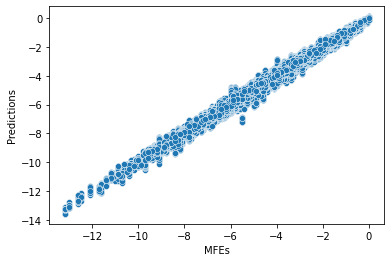

In [13]:
import seaborn as sns

sns.scatterplot(x="MFEs", y="Predictions", data=perfdf)

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

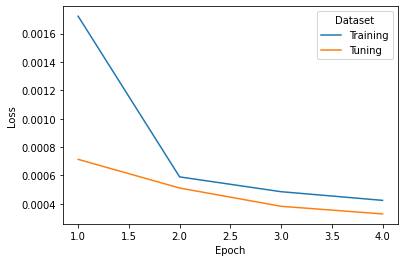

In [14]:
sns.lineplot(x="Epoch", y="Loss", hue="Dataset", data=logdf)